#Environment Setup

##**Confirming High Resource Run Time**

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun May  1 03:05:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


##**Including Facenet and MTCNN**

In [ ]:
!pip install facenet-pytorch

In [ ]:
!pip install mtcnn

##**Including All Dependencies for Notebook**

In [ ]:
import numpy as np
from numpy.linalg import norm
import pickle
from tqdm import tqdm, tqdm_notebook
import os
import random
import time
import math
from facenet_pytorch import MTCNN, InceptionResnetV1
import numpy as np
import tensorflow_datasets as tfds
import tensorflow
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import PIL
from PIL import Image
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import torch
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

%matplotlib inline


##**Using gdown to retrieve images**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! gdown http://vis-www.cs.umass.edu/lfw/lfw.tgz --output lfw.tar.gz
! tar -xvf lfw.tar.gz

Streaming output truncated to the last 5000 lines.
lfw/Luis_Sanchez/
lfw/Luis_Sanchez/Luis_Sanchez_0001.jpg
lfw/Juliette_Binoche/
lfw/Juliette_Binoche/Juliette_Binoche_0001.jpg
lfw/Joel_Todd/
lfw/Joel_Todd/Joel_Todd_0001.jpg
lfw/Allan_Wagner/
lfw/Allan_Wagner/Allan_Wagner_0001.jpg
lfw/Alejandro_Fernandez/
lfw/Alejandro_Fernandez/Alejandro_Fernandez_0001.jpg
lfw/Guillaume_Depardieu/
lfw/Guillaume_Depardieu/Guillaume_Depardieu_0001.jpg
lfw/Delphine_Chuillot/
lfw/Delphine_Chuillot/Delphine_Chuillot_0001.jpg
lfw/Paul_LeClerc/
lfw/Paul_LeClerc/Paul_LeClerc_0001.jpg
lfw/Eddie_Jordan/
lfw/Eddie_Jordan/Eddie_Jordan_0001.jpg
lfw/Lionel_Richie/
lfw/Lionel_Richie/Lionel_Richie_0001.jpg
lfw/Lionel_Richie/Lionel_Richie_0002.jpg
lfw/Jose_Viegas_Filho/
lfw/Jose_Viegas_Filho/Jose_Viegas_Filho_0001.jpg
lfw/Jose_Viegas_Filho/Jose_Viegas_Filho_0002.jpg
lfw/Roger_Mahony/
lfw/Roger_Mahony/Roger_Mahony_0001.jpg
lfw/Clay_Aiken/
lfw/Clay_Aiken/Clay_Aiken_0001.jpg
lfw/Clay_Aiken/Clay_Aiken_0002.jpg
lfw/Clay_Ai

##**Retrieve File Paths**

Helper function to retrieve LFW images from root directory once gdown is complete with image retrieval and the drive has been mounted.

In [ ]:
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']

def get_file_list(root_dir):
    file_list = []
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                filepath = os.path.join(root, filename)
                if os.path.exists(filepath):
                  file_list.append(filepath)
                else:
                  print(filepath)
    return file_list

Confirm that all 13233 images in the dataset have been downloaded successfully. 

In [ ]:
from sklearn.model_selection import train_test_split

# path to the datasets
root_dir = '/content/lfw'
filenames = sorted(get_file_list(root_dir))
print(len(filenames))

13233


Identify and group together the images basd on the names of the people represented. Generate counts of images per class (person) and retrieve index positions for images belonging to classes with atleast 5 representative images for later evaluation. 

In [ ]:
# Helper function to get the classname (or the person the image belongs to) for the image
def classname(str):
    return str.split('/')[-2]

#Collect all classes
classes = []

for i in tqdm_notebook(range(len(filenames))):
    classes.append(classname(filenames[i]))

#Collect the number of images per class and collect into a dictionary
freq = {} 
for item in classes: 
  if (item in freq): 
    freq[item] += 1
  else: 
    freq[item] = 1

#Collect the counts and the frequencies for the images in multi-cardinality classes where cardinality > 4. 
count = 0
multi = {}
for key in freq:
  if freq[key] > 4:
    count+=1
    multi[key] = freq[key]

#Retrieve index locations in database of images for these images.
repeated_images = 0
for key in multi:
  repeated_images += multi[key]

filenames_multi = []
indexes_multi = []

for i in tqdm_notebook(range(len(filenames))):
    if classname(filenames[i]) in multi:
      filenames_multi.append(filenames[i])
      indexes_multi.append(i)

print()
print()
print("The number of people with atleast 5 images in the data set are: ", count)
print("The number of images in the data set belonging to a class with atleast 5 images in it are: ", repeated_images)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/13233 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/13233 [00:00<?, ?it/s]



The number of people with atleast 5 images in the data set are:  423
The number of images in the data set belonging to a class with atleast 5 images in it are:  5985


In [ ]:
#Index Positions of images belonging to classes with multiple images ( > 4)
print(indexes_multi)

[31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 120, 121, 122, 123, 124, 132, 133, 134, 135, 136, 161, 162, 163, 164, 165, 166, 167, 168, 173, 174, 175, 176, 177, 178, 179, 186, 187, 188, 189, 190, 201, 202, 203, 204, 205, 209, 210, 211, 212, 213, 214, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 357, 358, 359, 360, 361, 362, 363, 364, 392, 393, 394, 395, 396, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 504, 505, 506, 507, 508, 509, 510, 512, 513, 514, 515, 516, 517, 518, 519, 535, 536

In [71]:
#Classes with multiple images ( > 4 ) and the class counts
print(len(multi))

423


In [69]:
print(len(indexes_multi))

5985


#**Baseline**

##**Overview**

In this section, an initial baseline reverse visual search engine is constructed by using a combination of a pre-trained model and a K-NearestNeighbor classifier. The pipeline for the baseline search engine is relatively straightforward:

1. Initially, a ResNet50 model and an InceptionResNet model were generated with imagenet weights.

2. These models were then used to extract the features across all of the images in the LFW dataset.

3. Two KNN classifiers were then fit across the embeddings generated in the previous step.

The combination of `{model: ResNet50, embeddings:feature_list1, neighbors1}` and
`{model: InceptionResNet, embeddings:feature_list2, neighbors2} ` are presented below as the baseline reverse visual search engines our team hoped to improve upon. 

##Generate Baseline Models and Embeddings

ResNet50 and InceptionResNetV2 models generated with pretrained weights based on imagenet. ResNet50 was chosen as one of the baseline models based on the provided AWS guide and overview. InceptionResNet was chosen as the other baseline model in order to highlight how the VGGFace weights and MTCNN training pipeline results in improved face recognition and capture on the improvements section. 

In [ ]:
model1 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='max')
model2 = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='max')

Helper function defined to use models to generate embeddings from the images in the LFW dataset. For the function below, when given an image path, the function will load the appropriate image and then convert it into an array for the models to generate embeddings on after passing through preprocessing. The generated embeddings are then flattened and normalized before being output. 

In [ ]:
def extract_features(img_path, model):
    input_shape = (224, 224, 3) #Input Shape for the baseline models selected
    img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1])) #Load images from the image data set directory
    img_array = image.img_to_array(img) #Convert image to array
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array) #Preprocess array
    features = model.predict(preprocessed_img) #Extract embeddings
    flattened_features = features.flatten() #Flatten and normalize
    normalized_features = flattened_features / norm(flattened_features) #Flatten and normalize
    return normalized_features

Function tested on first test image in the dataset; the ResNet50 model generated 2048 embeddings per image while InceptionResnetV2 generated 1536 embeddings per image. 

In [ ]:
features = extract_features('/content/lfw/AJ_Cook/AJ_Cook_0001.jpg', model1)
print("Total length of features for one image using resnet: ", len(features))

features = extract_features('/content/lfw/AJ_Cook/AJ_Cook_0001.jpg', model2)
print("Total length of features for one image using inception: ", len(features))

Total length of features for one image using resnet:  2048
Total length of features for one image using inception:  1536


Embeddings extracted from all images in the dataset to construct a database of embeddings for the classifier. 

In [ ]:
resnet__feature_list = []
for i in tqdm_notebook(range(len(filenames))):
    resnet__feature_list.append(extract_features(filenames[i], model1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/13233 [00:00<?, ?it/s]

In [ ]:
inception_feature_list = []
for i in tqdm_notebook(range(len(filenames))):
    inception_feature_list.append(extract_features(filenames[i], model2))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/13233 [00:00<?, ?it/s]

In [ ]:
np.savetxt("resnet__feature_list.csv", 
           resnet__feature_list,
           delimiter =", ")

np.savetxt("inception_feature_list.csv", 
           inception_feature_list,
           delimiter =", ")

Embeddings set to be used as the feature list in KNN classification; please uncomment the load command if you are working with the csv file generated in the previous step. 

In [ ]:
feature_list1 = np.array(resnet__feature_list)
feature_list2 = np.array(inception_feature_list)

#feature_list1 = np.loadtxt('resnet__feature_list.csv', float, delimiter=',')
#feature_list2 = np.loadtxt('inception_feature_list.csv', float, delimiter=',')

In [ ]:
print("Num images   = ", len(filenames))
print("Shape of feature_list for resnet = ", feature_list1.shape)
print("Shape of feature_list for inception = ", feature_list2.shape)

Num images   =  13233
Shape of feature_list for resnet =  (13233, 2048)
Shape of feature_list for inception =  (13233, 1536)


In [ ]:
num_images = len(filenames)
num_features_per_image = len(feature_list1[0])
print("Number of images = ", num_images)
print("Number of features per image for resnet = ", num_features_per_image)

num_images = len(filenames)
num_features_per_image = len(feature_list2[0])
print("Number of features per image for inception = ", num_features_per_image)

Number of images =  13233
Number of features per image for resnet =  2048
Number of features per image for inception =  1536


##**Setup Classifier for Baseline Models**

In [ ]:
# Helper function to get the filename for the image
def classname_filename(str):
    return str.split('/')[-1]


# Helper functions to plot the nearest images given a query image
def plot_images(filenames, distances):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20, 10))
    columns = 4
    for i, image in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        ax.grid(False)
        if i == 0:
            ax.set_title("Query Image\n" + classname_filename(filenames[i]))
        else:
            ax.set_title("Similar Image\n" + classname_filename(filenames[i]) +
                         "\nDistance: " +
                         str(float("{0:.2f}".format(distances[i]))))
        plt.imshow(image)

In [ ]:
neighbors1 = NearestNeighbors(n_neighbors=5,
                             algorithm='brute',
                             metric='euclidean').fit(feature_list1)

neighbors2 = NearestNeighbors(n_neighbors=5,
                             algorithm='brute',
                             metric='euclidean').fit(feature_list2)

#**Qualitative Performance Review for Baseline**

###**ResNet50 + KNN**

5 queries were generated for the baseline ResNet50 + KNN classifier pipeline. This was done by:

1. Choosing 5 randomly selected images at index locations known to contain images belonging to a person that has atleast 5 images in the database. 

2. For each of those images, querying the database using the classifier fit to the ResNet50 feature list.

3. Generating the images and distances for the top 5 neighbors and displaying the top 3 neighbors that the pipeline selects.

Since the queried images belong to people who have more than one image inside the database, if the pipeline performed perfectly, all retrieved images should belong to the same class as the queried image.

From the images below, we can see that the ResNet50 model produces images belonging to the correct class for some queried images, but also produces a number of images where none of the returned images belong to the queried image class. 

Finally, we also generate the time taken to retrieve similar images from the database per query image; we can see that this query time is at around **0.095 seconds** per query. 

Time taken to retrieve images:  0.09199333190917969
Time taken to retrieve images:  0.09751653671264648
Time taken to retrieve images:  0.09872102737426758
Time taken to retrieve images:  0.09212231636047363
Time taken to retrieve images:  0.09589743614196777


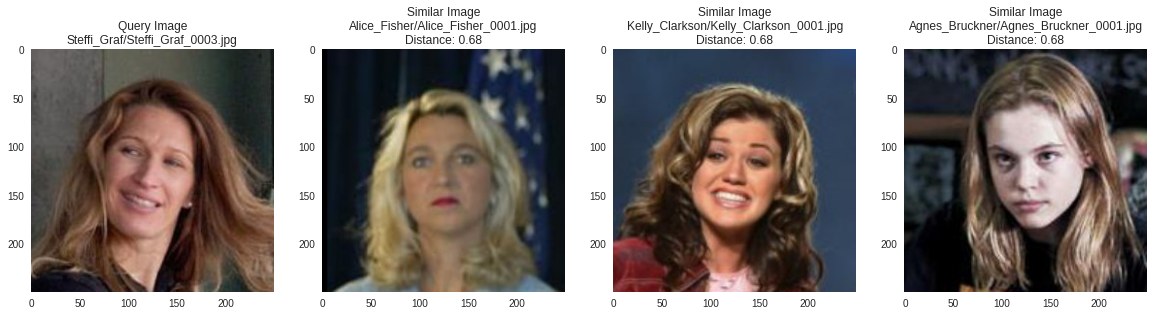

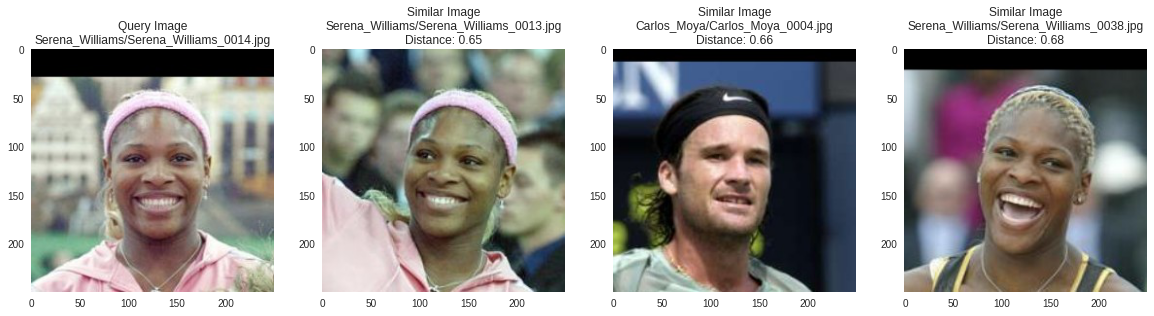

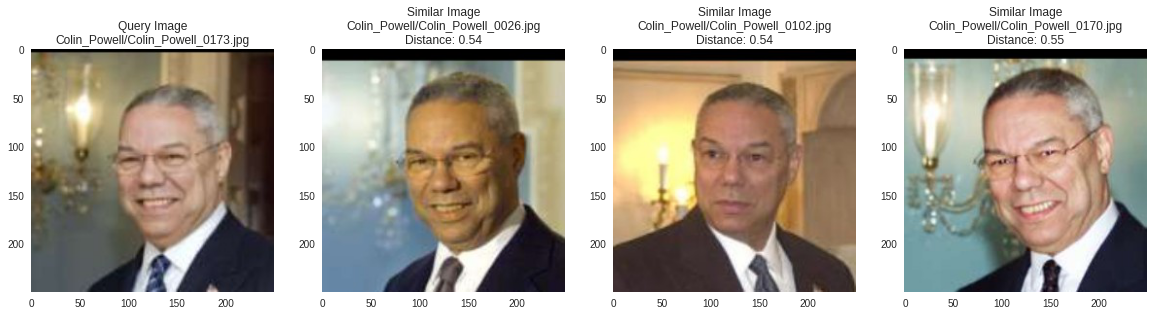

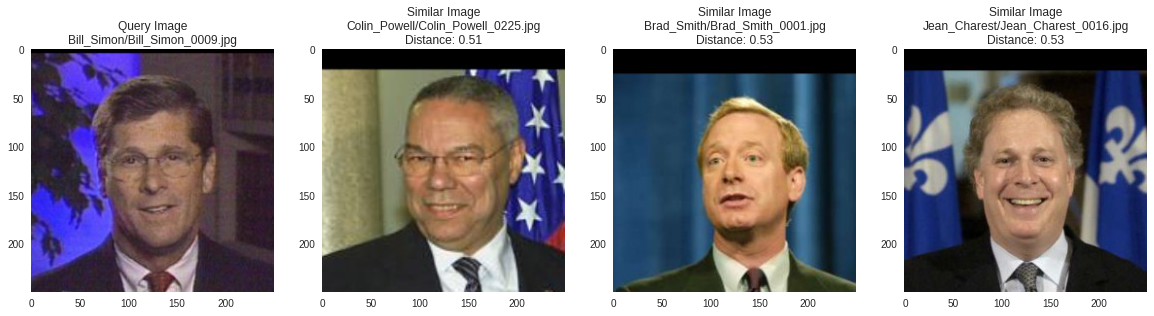

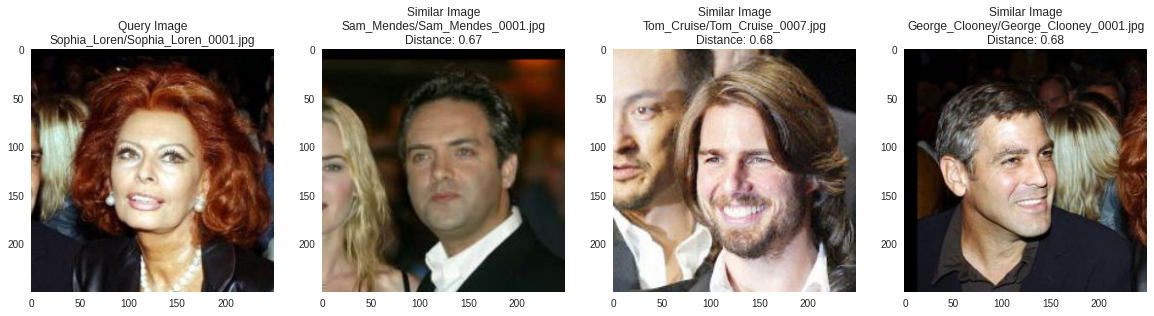

In [ ]:
for i in range(5):
    random_image_index = random.choice(indexes_multi)
    start = time.time()
    distances, indices = neighbors1.kneighbors(
        [feature_list1[random_image_index]])
    end = time.time()
    # Don't take the first closest image as it will be the same image
    similar_image_paths = [filenames[random_image_index]] + \
        [filenames[indices[0][i]] for i in range(1, 4)]
    plot_images(similar_image_paths, distances[0])
    print("Time taken to retrieve images: ", end - start)

###**InceptionResNet + KNN**

5 queries were generated for the baseline InceptionResNet + KNN classifier pipeline. This was done by:

1. Choosing 5 randomly selected images at index locations known to contain images belonging to a person that has atleast 5 images in the database. 

2. For each of those images, querying the database using the classifier fit to the ResNet50 feature list.

3. Generating the images and distances for the top 5 neighbors and displaying the top 3 neighbors that the pipeline selects.

Since the queried images belong to people who have more than one image inside the database, if the pipeline performed perfectly, all retrieved images should belong to the same class as the queried image.

From the images below, we can see that the InceptionResNet model produces results that seem even worse than the ResNet50 model! For a number of queried images, it seems as if the pipeline is just randomly selecting an output image and does not understand the visual context within the query image. 

Finally, we also generate the time taken to retrieve similar images from the database per query image; we can see that this query time is at around **0.082 seconds** per query. 

Time taken to retrieve images:  0.06514668464660645
Time taken to retrieve images:  0.0712432861328125
Time taken to retrieve images:  0.09446597099304199
Time taken to retrieve images:  0.07267308235168457
Time taken to retrieve images:  0.08703374862670898


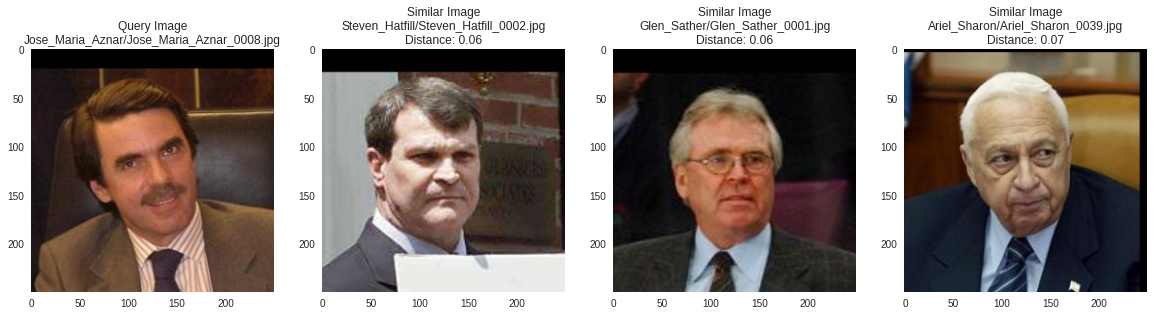

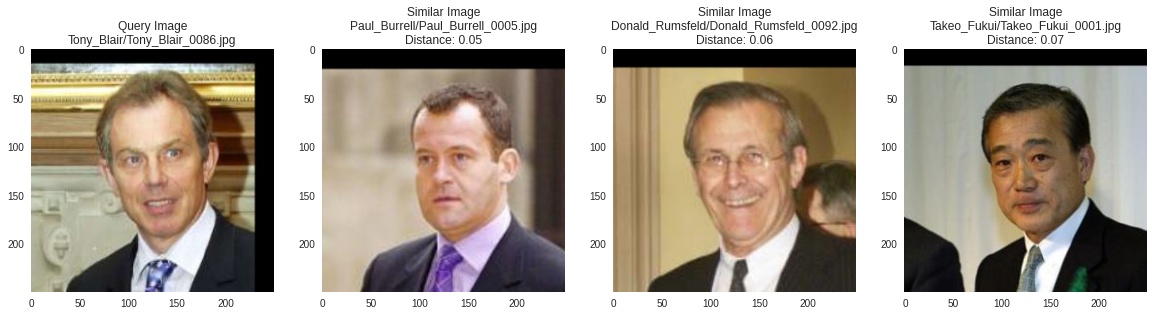

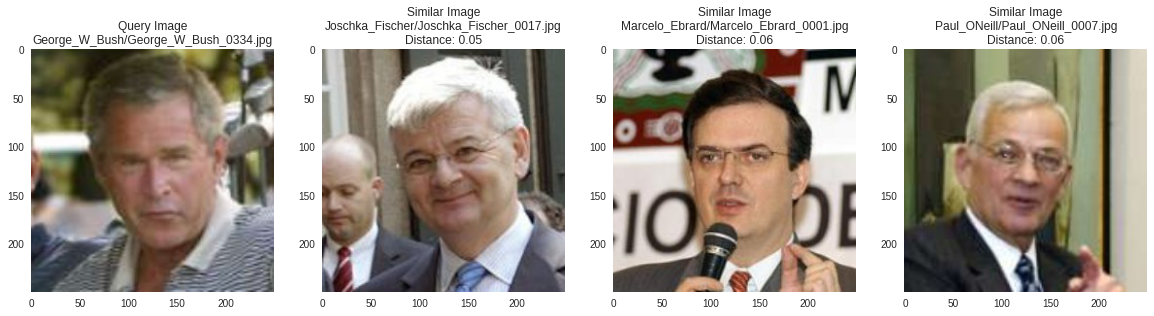

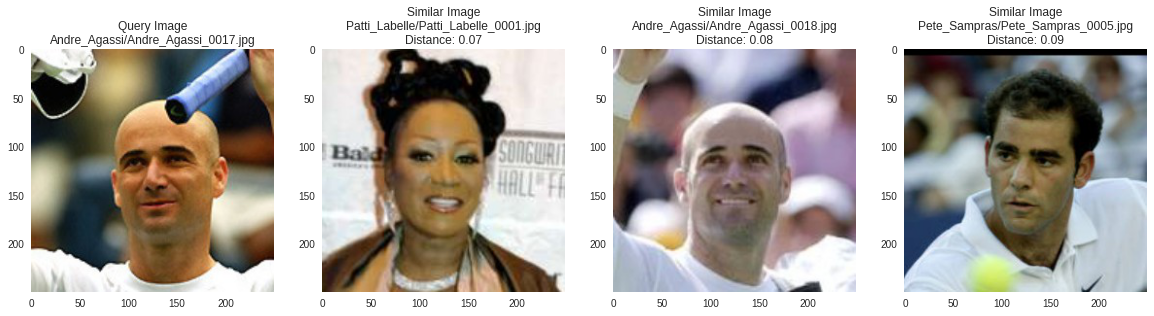

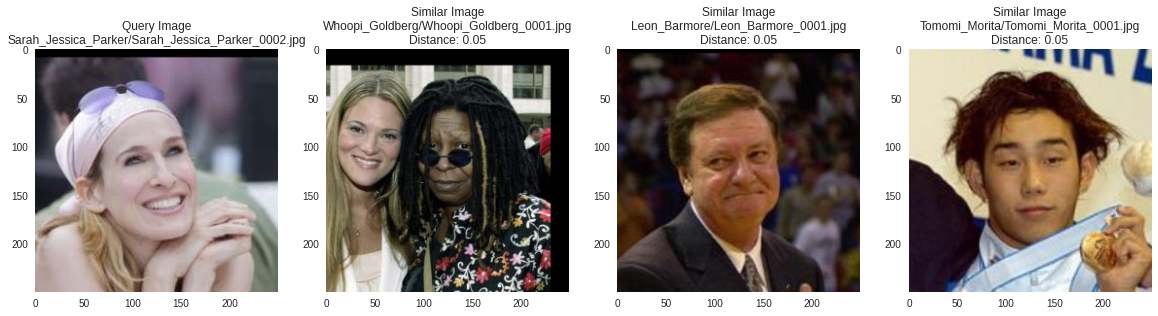

In [ ]:
for i in range(5):
    random_image_index = random.choice(indexes_multi)
    start = time.time()
    distances, indices = neighbors2.kneighbors(
        [feature_list2[random_image_index]])
    end = time.time()
    # Don't take the first closest image as it will be the same image
    similar_image_paths = [filenames[random_image_index]] + \
        [filenames[indices[0][i]] for i in range(1, 4)]
    plot_images(similar_image_paths, distances[0])
    print("Time taken to retrieve images: ", end - start)

#**Quantitative Performance Review for Baseline**

Earlier during the setup portion of the notebook, we collected all filepath indices belonging to images that belong to a person that had atleast 5 images represented within the database. Below, we propose an accuracy metric for the image search pipeline on LFW using this subset of images.

The function below takes as input the extracted embeddings from a given model and the index locations belonging to images that belong to a person that had atleast 5 images represented within the database. For the embeddings provided, it fits a KNN classifier that will retrieve the top 5 neighbors based on the embeddings. For each of these 5 guesses per query image, a correct prediction is one where the output image belongs to the class that is being queried. 

The number of people with atleast 5 images in the data set are:  **423**

The number of images in the data set belonging to a class with atleast 5 images in it are:  **5985**

Therefore, the metric below will generate **5985 * 4** predictions and there are **5985 * 4** or **23940** total **possible correct predictions**. 

100% implies that all predictions perfectly belonged to one of the 423 classes these images belong to. 

In [65]:
def calculate_accuracy(feature_list, multi_indices):
    num_nearest_neighbors = 5
    correct_prediction = 0
    incorrect_prediction = 0
    neighbors = NearestNeighbors(n_neighbors=num_nearest_neighbors,
                                 algorithm='brute',
                                 metric='euclidean').fit(feature_list)
    start = time.time()
    for i in range(len(multi_indices)):
        distances, indices = neighbors.kneighbors([feature_list[multi_indices[i]]])
        for j in range(1, num_nearest_neighbors):
            if (classname(filenames[multi_indices[i]]) == classname(filenames[indices[0][j]])):
                correct_prediction += 1
            else:
                incorrect_prediction += 1
    end = time.time()
    accuracy = round(
        100.0 * correct_prediction /
        (1.0 * correct_prediction + incorrect_prediction), 2), end - start, correct_prediction
    return accuracy

###**ResNet50 + KNN**

As expected from the qualitative analysis above, the ResNet50 baseline pipeline performs quite poorly. It takes a total of **619 seconds** to complete the image retrieval task across all 5985 query images. The accuracy is **15.97** percent, with **3824** correct predictions. 

In [66]:
calculate_accuracy(feature_list1, indexes_multi)

(15.97, 619.6020786762238, 3824)

###**InceptionResNet + KNN**

The InceptionResNet baseline pipeline performs even worse! It takes a total of **374.4 seconds** to complete the image retrieval task across all 5985 query images. The accuracy is **2.13** percent, with **510** correct predictions. 

In [67]:
calculate_accuracy(feature_list2, indexes_multi)

(2.13, 374.40247344970703, 510)

#**Model Improvements**

For improvements over the baseline models, we made a number of changes to the overall image search pipeline.

1. Firstly, we generated the embeddings for the classifier using FaceNet.
2. We then ran PCA on the generated FaceNet embeddings to reduce the dimensions of the embeddings to improve query time.
3. We further improved upon the query time by implementing Annoy indexing on the feature list.

These improvements are detailed below.

###**Improved Embeddings with FaceNet**

###**Architecture and Objective Function for FaceNet as Motivation**

FaceNet is an record-breaking facial recognition system proposed by Google Research in 2015. It achieves high performance facial recognition by first generating high quality face mappings using various deep learning architectures and methodologies (for our purposes, we will use **MTCNN** to generate face mappings) and trains an architecture such as **InceptionResNet** with **triplet loss** as the loss function. 

A **siamese network** is a dual network with identical weights and architecture that takes an image of a person as input and then generates the image embeddings of it. The same network is then used without any updates to create embeddings for another image. Finally a similarity score will be computed using the two embeddings to decide whether two image all same person or not. 

With a **triplet loss function**, the process is similar. Triplet loss comes with three images, **Anchor, Positive and Negative**. Anchor and Positive image will fall into same class (i.e same person) and Anchor and Negative will be different class. The embeddings for these three images will then be generated using the same network and a triplet loss function will be used to compute the loss value for this triplet set. The triplet loss function computes the euclidean distance between Anchor and Positive and also between Anchor and Negative. The distance between Anchor and Positive should be smaller than distance between Anchor and Negative. The actual triplet loss is shown below.

$$
L = \max(d(A, P)-d(A,N)+\text {margin}, 0)
$$


As we can see, in order to minimize the triplet loss function the models needs to generate vectors for Anchor and Positive images as close as possible in euclidean space and also generate vectors for Anchor and Negative as far from each other as possible. Margin will be a hyperparameter that controls how far away the dissimilarities for a triplet should be. By using the triplet loss function Facenet will learn to create image embeddings near to each other for images that falls into same class.

###**Using facenet-pytorch to generate embeddings**


The facenet-pytorch package provides easy-to-use FaceNet implementation using Pytorch. We will use its MTCNN and InceptionResnetV1 classes in our experiment. The MTCNN class is a face landmark detector which can cut the original LFW images down to contain only the "facial features". The InceptionResnetV1 class with parameter "pretrained" set as "vggface2" loads a pretrained Inception Resnet V1 network, which is the network described in the FaceNet paper. 

In [ ]:
# use GPU if we have one
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

# mtcnn is required by facenet, it will find and align faces in image
mtcnn = MTCNN(device=device)

# pretrained facenet
model = InceptionResnetV1(pretrained='vggface2', device=device).eval()


with open('vectors.csv', 'ab') as f:
  for i in tqdm_notebook(range(len(filenames))):
    input_shape = (250, 250, 3)
    img = image.load_img(filenames[i],
                         target_size=(input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img, dtype="uint8")
    aligned = mtcnn(img_array).to(device)
    vectors = model(aligned[None, :]).detach().cpu()
    #flattened_features = vectors.flatten()
    #normalized_vectors = flattened_features / norm(flattened_features)
    np.savetxt(f, vectors, delimiter=',')
    #np.savetxt(f, normalized_vectors, delimiter=',')

    torch.cuda.empty_cache()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/13233 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


In [ ]:
vectors = np.loadtxt('vectors.csv', float, delimiter=',')

In [73]:
print("Num images   = ", len(filenames))
print("Shape of feature_list for FaceNet = ", vectors.shape)

Num images   =  13233
Shape of feature_list for FaceNet =  (13233, 512)


In [74]:
num_images = len(filenames)
num_features_per_image = len(vectors[0])
print("Number of images = ", num_images)
print("Number of features per image for FaceNet = ", num_features_per_image)

Number of images =  13233
Number of features per image for FaceNet =  512


###**Setup Classifier for Baseline Models**

In [ ]:
neighbors = NearestNeighbors(n_neighbors=5,
                             algorithm='brute',
                             metric='euclidean').fit(vectors)

###**Qualitative Performance Review for FaceNet**

5 queries were generated for the FaceNet + KNN classifier pipeline. This was done by:

1. Choosing 5 randomly selected images at index locations known to contain images belonging to a person that has atleast 5 images in the database.

2. For each of those images, querying the database using the classifier fit to the FaceNet feature list.

3. Generating the images and distances for the top 5 neighbors and displaying the top 3 neighbors that the pipeline selects.

Since the queried images belong to people who have more than one image inside the database, if the pipeline performed perfectly, all retrieved images should belong to the same class as the queried image.

From the images below, we can see that unlike before, the images produced by FaceNet queries reliably belong to the correct person being queried!

Finally, we also generate the time taken to retrieve similar images from the database per query image; we can see that this query time is at around 0.015 seconds per query and is faster then both baselines observed before. 

Time taken to retrieve images:  0.013832807540893555
Time taken to retrieve images:  0.014679670333862305
Time taken to retrieve images:  0.014220237731933594
Time taken to retrieve images:  0.016967058181762695
Time taken to retrieve images:  0.013875007629394531


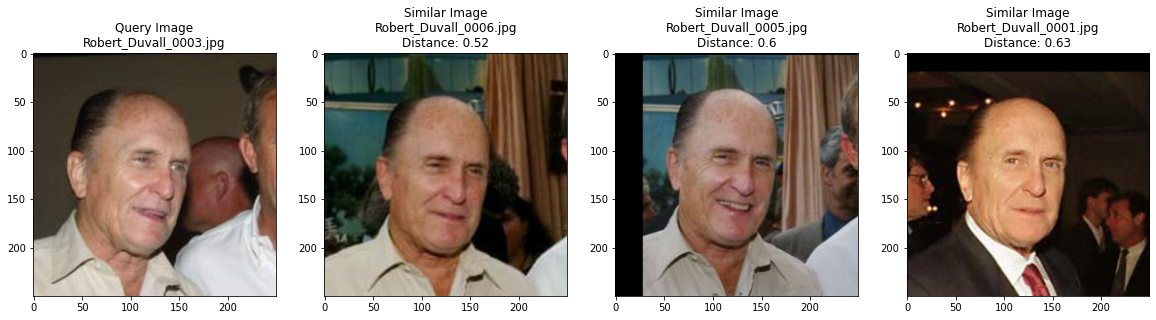

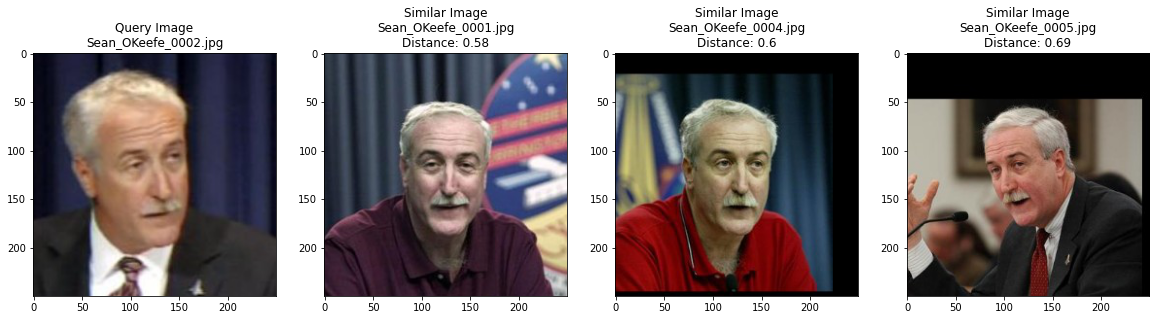

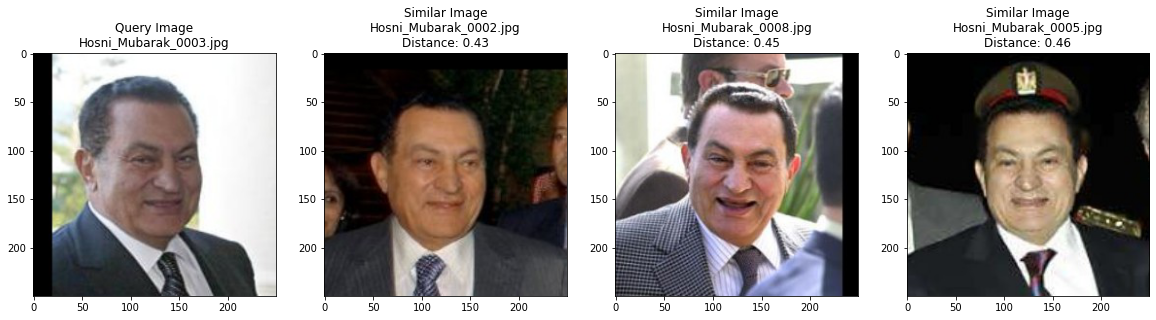

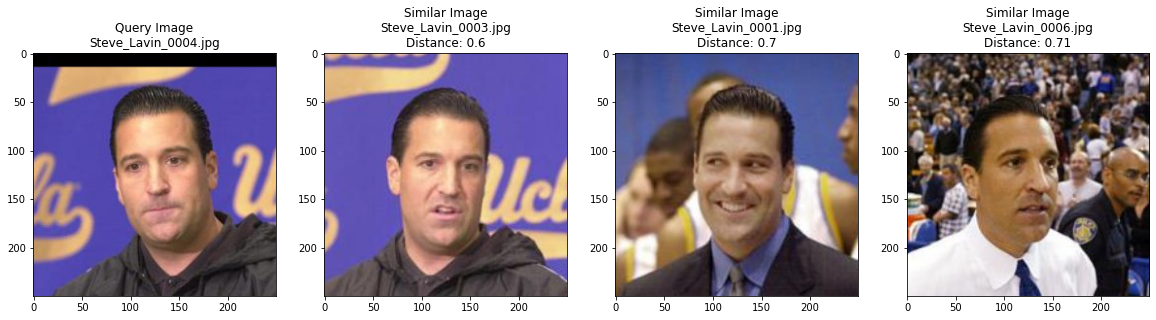

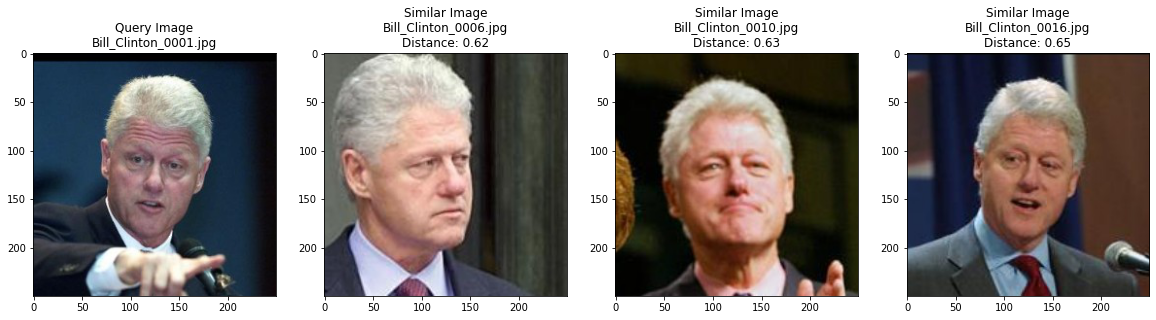

In [ ]:
for i in range(5):
    random_image_index = random.choice(indexes_multi)
    start = time.time()
    distances, indices = neighbors.kneighbors(
        [vectors[random_image_index]])
    end = time.time()
    # Don't take the first closest image as it will be the same image
    similar_image_paths = [filenames[random_image_index]] + \
        [filenames[indices[0][i]] for i in range(1, 4)]
    plot_images(similar_image_paths, distances[0])
    print("Time taken to retrieve images: ", end - start)


###**Quantitative Performance Review for FaceNet**

We repeat the accuracy evaluation from before to confirm our suspicions from the qualitative review.  Unlike before, FaceNet produces **significantly** better predictions. Our accuracy is now at **94.1**% with a whopping **22527** correct predictions out of the  23940 total possible correct predictions. 

FaceNet also performs faster as well, requiring only **84** seconds to complete the evaluation. 

In [75]:
calculate_accuracy(vectors, indexes_multi)

(94.1, 84.07623362541199, 22527)

###**Reducing Embedding Dimensions with PCA for FaceNet**

In [ ]:
feature_list = vectors

In [ ]:
num_images = len(filenames)
num_features_per_image = len(feature_list[0])
print("Number of images = ", num_images)
print("Number of features per image = ", num_features_per_image)

In [ ]:
# Helper function to get the classname and filename
def classname_filename(str):
    return str.split('/')[-2] + '/' + str.split('/')[-1]


# Helper function that calculates accuracy using the nearest neighbors brute force algorithm
def calculate_accuracy(feature_list, multi_indices):
    num_nearest_neighbors = 5
    correct_prediction = 0
    incorrect_prediction = 0
    neighbors = NearestNeighbors(n_neighbors=num_nearest_neighbors,
                                 algorithm='brute',
                                 metric='euclidean').fit(feature_list)
    start = time.time()
    for i in range(len(multi_indices)):
        distances, indices = neighbors.kneighbors([feature_list[multi_indices[i]]])
        for j in range(1, num_nearest_neighbors):
            if (classname(filenames[multi_indices[i]]) == classname(filenames[indices[0][j]])):
                correct_prediction += 1
            else:
                incorrect_prediction += 1
    end = time.time()
    accuracy = round(
        100.0 * correct_prediction /
        (1.0 * correct_prediction + incorrect_prediction), 2), end - start
    return accuracy

In [ ]:
print("Accuracy on original feature set : ",
      calculate_accuracy(feature_list[:], indexes_multi))

In [ ]:
pca_dimensions = [1, 2, 3, 4, 5, 10, 20, 50, 75, 100, 150, 256, 512]
pca_accuracy = []
pca_time = []

for dimensions in pca_dimensions:
    pca = PCA(n_components=dimensions)
    pca.fit(feature_list)
    feature_list_compressed = pca.transform(feature_list[:])
    # Calculate accuracy over the compressed features
    accuracy, t = calculate_accuracy(feature_list_compressed[:], indexes_multi)
    pca_time.append(t)
    pca_accuracy.append(accuracy)
    print("For PCA Dimensions = ", dimensions, ",\tAccuracy = ", accuracy, "%",
          ",\tTime = ", pca_time[-1])

In [ ]:
f = plt.figure()

matplotlib.style.use('seaborn')
plt.plot(pca_time, pca_accuracy, 'o--', markersize=5)
for label, x, y in zip(pca_dimensions, pca_time, pca_accuracy):
    plt.annotate(label, xy=(x, y), ha='right', va='bottom')
plt.title('Test Time vs Accuracy for each PCA dimension')
plt.xlabel('Test Time')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In [ ]:
f = plt.figure()

matplotlib.style.use('seaborn')
plt.plot(range(1, 513), pca.explained_variance_ratio_, 'o--', markersize=3)
plt.title('Variance vs number of PCA dimensions')
plt.xlabel('PCA Dimension Count')
plt.ylabel('Variance')
plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
f = plt.figure()

matplotlib.style.use('seaborn')
plt.plot(range(1, 513),
         pca.explained_variance_ratio_.cumsum(),
         'o--',
         markersize=3)
plt.title('Cumulative Variance vs number of PCA dimensions')
plt.xlabel('PCA Dimension Count')
plt.ylabel('Cumulative Variance')
plt.grid(True)
plt.show()

In [ ]:
pca = PCA(n_components=50)
pca.fit(feature_list)
feature_list_compressed = pca.transform(feature_list[:])

In [ ]:
feature_list_compressed.shape

In [ ]:
neighbors = NearestNeighbors(n_neighbors=5,
                             algorithm='brute',
                             metric='euclidean').fit(feature_list_compressed)

In [ ]:
for i in range(5):
    random_image_index = random.choice(indexes_multi)
    distances, indices = neighbors.kneighbors(
        [feature_list_compressed[random_image_index]])
    # Don't take the first closest image as it will be the same image
    similar_image_paths = [filenames[random_image_index]] + \
        [filenames[indices[0][i]] for i in range(1, 4)]
    plot_images(similar_image_paths, distances[0])

In [ ]:
c_id = []
for i in range(len(vectors[indexes_multi])):
  c_id.append(i)

In [ ]:
tsne_results = TSNE(n_components=2,verbose=1,metric='euclidean').fit_transform(vectors[indexes_multi])

In [ ]:
plt.figure(figsize=(20, 15))
colormap = plt.cm.get_cmap('coolwarm')
scatter_plot = plt.scatter(tsne_results[:,0],tsne_results[:,1], c = c_id, cmap=colormap)
plt.colorbar(scatter_plot)
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
tsne_results = TSNE(n_components=2,verbose=1,metric='euclidean').fit_transform(feature_list_compressed[indexes_multi])

In [ ]:
plt.figure(figsize=(20, 15))
colormap = plt.cm.get_cmap('coolwarm')
scatter_plot = plt.scatter(tsne_results[:,0],tsne_results[:,1], c = c_id, cmap=colormap)
plt.colorbar(scatter_plot)
plt.show()

###**Setting Up Annoy Index for super fast queries**

In [ ]:
!pip3 install annoy


In [ ]:
from annoy import AnnoyIndex

annoy_index = AnnoyIndex(feature_list_compressed.shape[1])  # Length of item vector that will be indexed
for i in range(feature_list_compressed.shape[0]):
    annoy_index.add_item(i, feature_list_compressed[i])
annoy_index.build(40)  #40 trees

In [ ]:
%timeit a = annoy_index.get_nns_by_vector(feature_list_compressed[0], 5, include_distances=True )

In [ ]:
a

Time taken to retrieve images:  0.00038123130798339844
Time taken to retrieve images:  0.00036215782165527344
Time taken to retrieve images:  0.00019550323486328125
Time taken to retrieve images:  0.00041961669921875
Time taken to retrieve images:  0.0007994174957275391


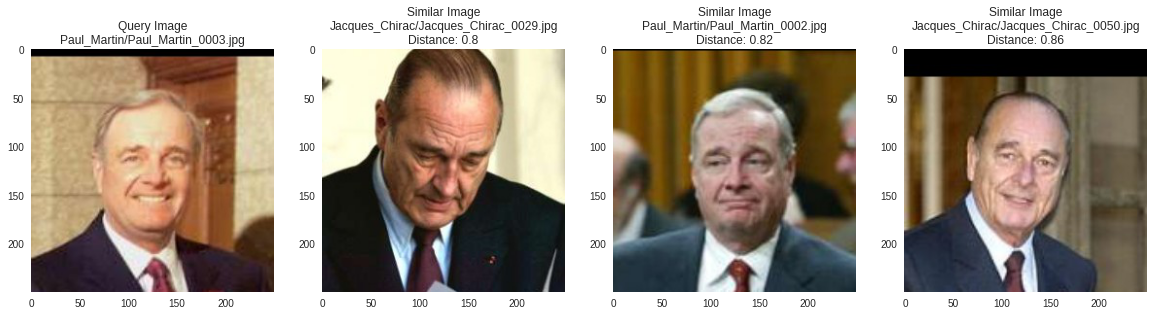

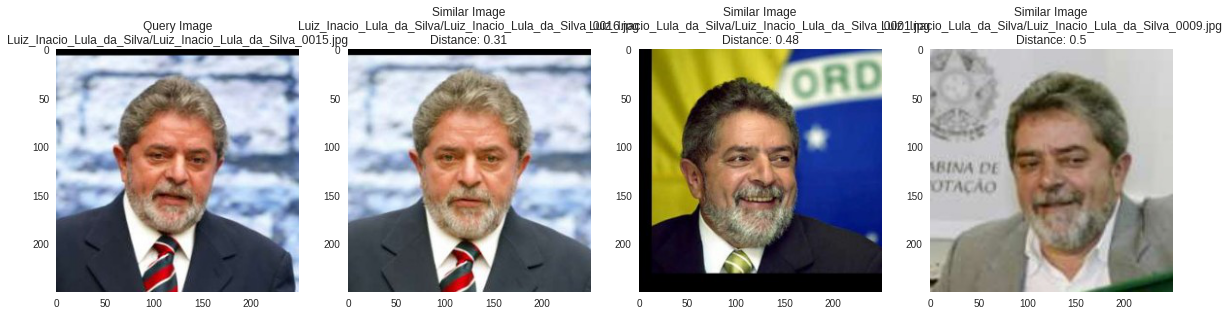

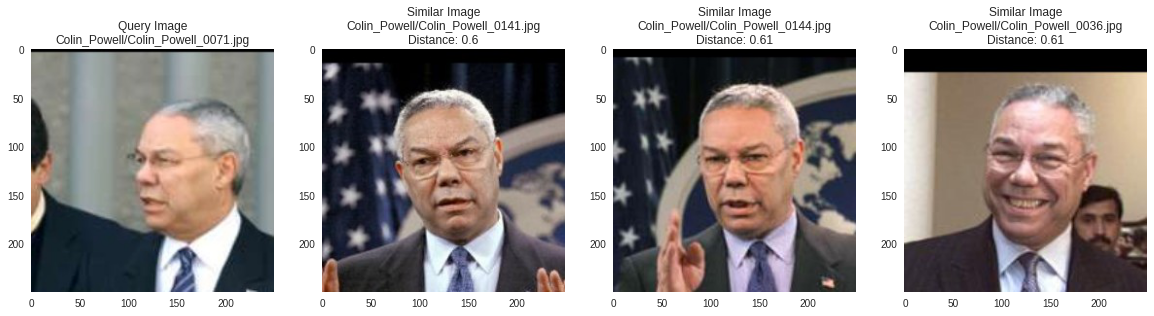

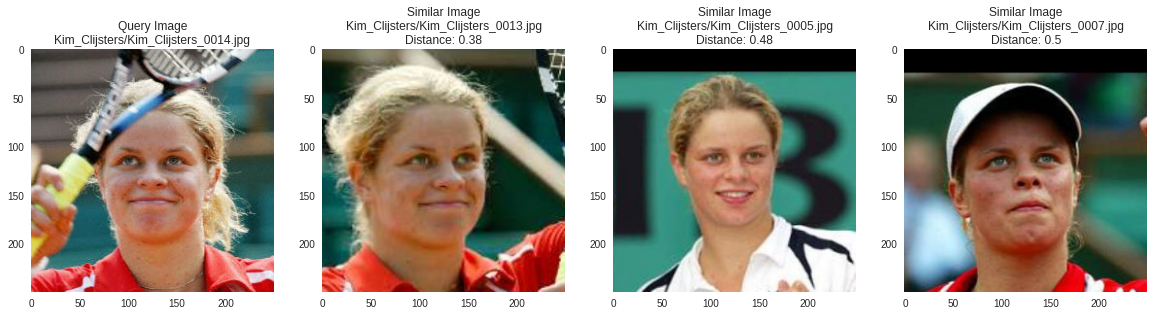

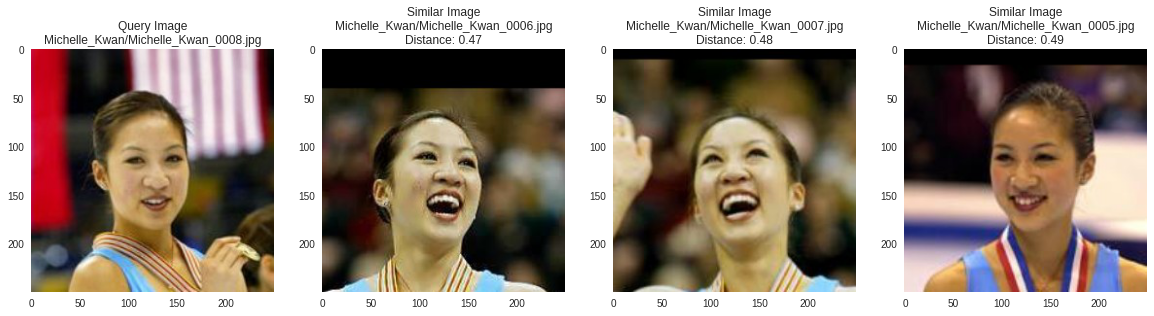

In [77]:
for i in range(5):
    random_image_index = random.choice(indexes_multi)
    start = time.time()
    indices, distances = annoy_index.get_nns_by_vector(feature_list_compressed[random_image_index], 5, include_distances=True )
    end = time.time()
    # Don't take the first closest image as it will be the same image
    similar_image_paths = [filenames[random_image_index]] + \
        [filenames[indices[i]] for i in range(1, 4)]
    plot_images(similar_image_paths, distances)
    print("Time taken to retrieve images: ", end - start)